# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
plt.rcParams.update({'font.size': 12})
import seaborn as sns

# Load Data

### Tranco

In [2]:
df_tranco = pd.read_pickle(f"../data/pkl/df_tranco.pkl.zst")
df_tranco.head()

,rank,domain
0,1,google.com
1,2,akamaiedge.net
2,3,facebook.com
3,4,youtube.com
4,5,netflix.com


In [3]:
dict_tranco_rank = df_tranco.set_index("domain")["rank"].to_dict()
dict_tranco_rank["netflix.com"]

5

### QUIC

In [4]:
df_quic = pd.read_pickle(f"../data/pkl/df_quicreach_handshakes.pkl.zst")
df_quic["tranco_rank"] = df_quic["domain"].map(dict_tranco_rank)
df_quic = df_quic[~df_quic["tranco_rank"].isnull()]
df_quic = df_quic[df_quic["initial_size"]==1362] # optimal intial size, leads to unique names
df_quic.head()

,domain,rtt,sent_tls_payload,recv_tls_payload,handshake_tag,sent_udp_payload,recv_udp_payload,ampl_factor,initial_size,tranco_rank
156,0-60specs.com,25.417000,289,2657,Amplification,1362,5119,3.8,1362,784207.0
226,0.plus,8.291000,282,2641,Amplification,1362,5103,3.7,1362,642293.0
253,00-tv.com,25.320999,285,2644,Amplification,1362,5106,3.7,1362,45942.0
281,00.ge,8.402000,281,2639,Amplification,1362,5101,3.7,1362,81715.0
309,00000.la,25.209000,284,4520,Multi-RTT,2724,7084,2.6,1362,405516.0


### TLS

In [5]:
df_tls = pd.read_pickle(f"../data/pkl/df_tls_certs.pkl.zst")
df_tls = df_tls.drop_duplicates(subset=["domain"], keep="last")
df_tls["tranco_rank"] = df_tls["domain"].map(dict_tranco_rank)
df_tls = df_tls[~df_tls["tranco_rank"].isnull()]
df_tls.head()

,domain,type,d,dt,certsize,tbssize,subjcn,subjhash,subjk,subjsize,...,sctcount,sctsize,extssize,sigalg,sigsize,validation,precert,ca,hash,tranco_rank
2,0-1.ir,LEAF,2,2,1315,1035,0-1.ir,54a78fa9554bdf23acf9f904cbf1f829a6e95693,259e6544d8a23a946330daab01dd4464028b85d7,19,...,2,246,484,SHA256-RSA,256,DV,False,False,7bec3730cd02e1f9be61e4db036f028c2d6d4a81d9480b...,146378.0
3,0-11-0.com,LEAF,0,0,1288,1008,www.stackssl.com,21b145e103c2e1465e6c7e68de0c2f9b59a3501b,c1de76d0eb2484971f8e1657e26f5ae3388d0921,29,...,0,0,440,SHA256-RSA,256,DV,False,False,f9cc586e274a96227aa09eca83052843b76fca404faa3b...,288724.0
17,0-60specs.com,LEAF,1,1,1342,1253,sni.cloudflaressl.com,692dd356163caca0af452c8e0a0e19c97807ea59,b84893b86a5087850952ed75fe8bcd093841127c,119,...,3,368,776,ECDSA-SHA256,70,OV,False,False,50cc24748ddd3d04473c39b0e5fac3c08a7f20e6152c28...,784207.0
20,0-casino.info,LEAF,2,2,1446,1166,0-casino.info,7bc58eca5a647f74f2a3c8614a4dc2d46505e3e7,1bff94857eec442eb2fff4afc017b309efc78d26,26,...,2,243,574,SHA256-RSA,256,DV,False,False,cf89e0ec5ce4b4a43661a587a2c92f0043397061701abc...,455390.0
30,0.gp,LEAF,2,2,1306,1026,0.gp,767545d11268bbdeb0f70d9539d6c222b50bb574,a45215c26fa99187713b894cce774d2e0ce16861,17,...,2,243,477,SHA256-RSA,256,DV,False,False,be01133409952b476b8f82d6d4213d7e566d1eaf01ff46...,499024.0


# Visualize Reachability Per Rank

In [6]:
# [0, 5] means 0 <= x <= 5 (closed)
# (0, 5) means 0 < x < 5 (open)
myBins_tls = pd.cut(df_tls["tranco_rank"],
            bins=[ 100000*i+1 for i in range(0, 11) ],
            right=False)

tmp = df_tls.groupby(myBins_tls).size().rename("HTTPS Services").to_frame()
tmp

,HTTPS Services
tranco_rank,
"[1, 100001)",79533
"[100001, 200001)",78117
"[200001, 300001)",78700
"[300001, 400001)",79391
"[400001, 500001)",79436
"[500001, 600001)",79007
"[600001, 700001)",79564
"[700001, 800001)",81262
"[800001, 900001)",78896


In [7]:
# repeat for QUIC frame
myBins_quic = pd.cut(df_quic["tranco_rank"],
            bins=[ 100000*i+1 for i in range(0, 11) ],
            right=False)

tmp["QUIC Services"] = df_quic.groupby(myBins_quic).size()

tmp["HTTPS only Services"] = tmp["HTTPS Services"]-tmp["QUIC Services"]
tmp = tmp[sorted(tmp.columns)]
tmp = tmp/100000*100
tmp

,HTTPS Services,HTTPS only Services,QUIC Services
tranco_rank,,,
"[1, 100001)",79.533,62.855,16.678
"[100001, 200001)",78.117,59.070,19.047
"[200001, 300001)",78.700,60.167,18.533
"[300001, 400001)",79.391,59.299,20.092
"[400001, 500001)",79.436,57.648,21.788
"[500001, 600001)",79.007,55.782,23.225
"[600001, 700001)",79.564,57.956,21.608
"[700001, 800001)",81.262,53.646,27.616
"[800001, 900001)",78.896,59.363,19.533


### Horizontal Bars (relative)

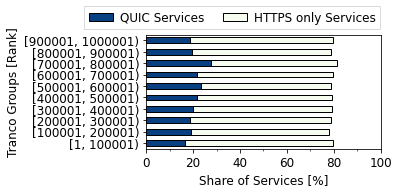

In [8]:
fsize_wide_barh = (6*0.7,3*0.7)  # (8*0.7,3*0.7)
ax = tmp[["QUIC Services", "HTTPS only Services"]].plot.barh(
       stacked=True, cmap="GnBu_r",
       figsize=fsize_wide_barh, xlim=(0,100),
       edgecolor="black", )

ax.set_xlabel("Share of Services [%]")
ax.set_ylabel("Tranco Groups [Rank]")
ax.legend(bbox_to_anchor=(1.025, 1.3),
          ncol=2, fancybox=False, shadow=False,
          handletextpad=0.6, columnspacing=1.5, framealpha=0.7)
ax.xaxis.set_minor_locator(MultipleLocator(10))
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)

fig = ax.get_figure()
fig.savefig(f"./plots/barh_reachable_quic_sites.pdf", bbox_inches='tight')
fig.savefig(f"./plots/barh_reachable_quic_sites.png", bbox_inches='tight', dpi=200)
plt.show()
plt.close(fig)

In [9]:
tmp.agg(["mean","median","std"])

,HTTPS Services,HTTPS only Services,QUIC Services
mean,79.362800,58.667500,20.695300
median,79.413500,59.184500,19.812500
std,0.826465,2.600223,3.073845


# Visualize Handshake Type per Rank

In [10]:
# prepare plot
tmp = df_quic.groupby([myBins_quic, "handshake_tag"]).size()
tmp = tmp.unstack()
tmp = tmp[["Amplification", "Multi-RTT", "RETRY", "1-RTT"]]
tmp = tmp.div(tmp.sum(axis=1), axis=0)*100
tmp

handshake_tag,Amplification,Multi-RTT,RETRY,1-RTT
tranco_rank,,,,
"[1, 100001)",64.180357,32.755726,0.041971,3.021945
"[100001, 200001)",64.461595,34.525122,0.068252,0.945031
"[200001, 300001)",62.860843,36.340582,0.043166,0.755409
"[300001, 400001)",64.314155,35.103524,0.079634,0.502688
"[400001, 500001)",63.296310,36.387002,0.027538,0.289150
"[500001, 600001)",61.433800,38.325081,0.034446,0.206674
"[600001, 700001)",56.553128,43.150685,0.064791,0.231396
"[700001, 800001)",57.499276,42.334154,0.010863,0.155707
"[800001, 900001)",56.796191,42.963190,0.061434,0.179184


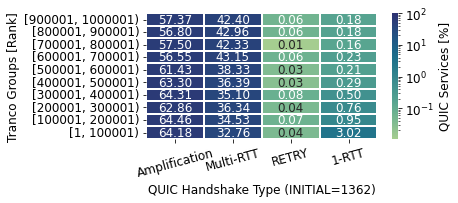

In [11]:
ax = sns.heatmap(tmp[::-1],
            annot=True,
            cmap=["vlag","flare","Spectral_r","cividis","crest"][4],
            norm=LogNorm(vmax=100),
            fmt='.2f', annot_kws={'rotation': 0},
            linewidths=0.1,
            cbar_kws={'label': 'QUIC Services [%]'})

plt.gcf().set_size_inches(7.4*0.7,3.3*0.7)
ax.set_xlabel(f"QUIC Handshake Type (INITIAL=1362)")
ax.set_ylabel("Tranco Groups [Rank]")
ax.tick_params(axis='x', rotation=15)

fig = ax.get_figure()
fig.savefig(f"./plots/heatmap_quic_handshake_types_per_rank_rel2.pdf", bbox_inches='tight')
fig.savefig(f"./plots/heatmap_quic_handshake_types_per_rank_rel2.png", bbox_inches='tight', dpi=200)
plt.show()
plt.close(fig)

In [12]:
tmp.agg(["mean","median","std"])

handshake_tag,Amplification,Multi-RTT,RETRY,1-RTT
mean,60.876304,38.428405,0.049050,0.646241
median,62.147321,37.356041,0.050787,0.260273
std,3.411574,3.956588,0.021113,0.878080
